# How does treeCODA behave with lambda_1?
## Producing supplementary figure 1 C-F (spike-and-slab LASSO prior)

In [1]:
# Setup
import pandas as pd
import toytree as tt
import numpy as np
import anndata as ad
import os
from tree_aggregation import tree_ana as ana
import matplotlib.pyplot as plt
import seaborn as sns
import sccoda.util.data_visualization as viz

Lets take one random dataset from the simulation study with 10 OTUs

0.9
50


<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

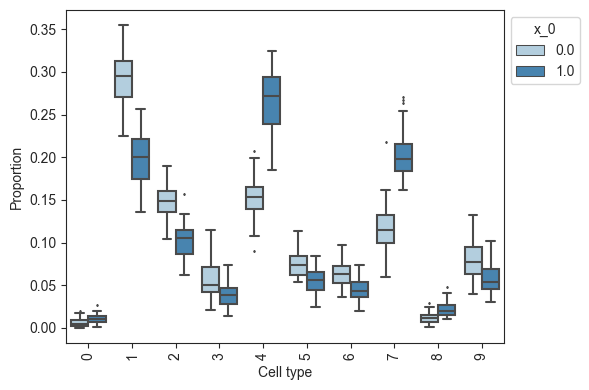

In [2]:
# id = 187
id = 319
dataset_path = os.path.abspath("../../../tascCODA_data/benchmarks/model_comparison/datasets/")

test_data = ad.read_h5ad(dataset_path + f"/data_{id}")
test_data.uns["phylo_tree"] = tt.tree(newick=test_data.uns["tree_newick"])
print(test_data.uns["effect_size"])
print(test_data.uns["num_samples"])

viz.boxplots(test_data, "x_0")

In [3]:
tt.tree(newick=test_data.uns["tree_newick"]).draw(tip_labels_align=True, node_sizes=10, node_labels='idx')

(<toyplot.canvas.Canvas at 0x7f7f863bd130>,
 <toytree.Render.ToytreeMark at 0x7f7f863bdf40>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="255.0px" height="275.0px" viewBox="0 0 255.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf15568ae7db74deb8ff4e5e21dc4087f"> 10 11 12 13 14 15 16 17 0 1 2 3 4 5 6 7 8 9

## Increasing $\lambda_0$ (Figure S1C)

[   1.      1.44    2.07    2.98    4.28    6.16    8.86   12.74   18.33
   26.37   37.93   54.56   78.48  112.88  162.38  233.57  335.98  483.29
  695.19 1000.  ]


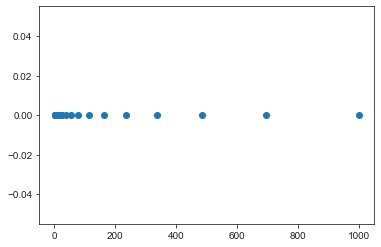

In [24]:
# Define lambdas
phi=0
results = {}

lambdas = np.round(np.logspace(start=0, stop=3, num=20), 2)
print(lambdas)
plt.plot(lambdas, np.zeros(len(lambdas)), 'o')


In [ ]:
# Apply tascCODA
for l in lambdas:

    tree_mod = ana.CompositionalAnalysisTree(
    test_data,
    reference_cell_type="9",
    formula="x_0",
    reg="scaled",
    pen_args={"lambda_0": l, "phi":phi, "lambda_1": 1},
    model="new"

    )
    tree_res = tree_mod.sample_hmc_da(num_results=20000, num_burnin=5000)
    results[l] = tree_res

In [32]:
thetas = pd.DataFrame({
    "l_0": lambdas,
    "theta": [np.mean(r.posterior["theta"].loc[{"x":0, "chain":0}]).item(0) for r in results.values()]
})
thetas.to_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/l0_theta")
for k, res in results.items():
    res.node_df.to_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/l0_{np.round(k, 2)}")

In [33]:
l0_thetas = pd.read_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/l0_theta", index_col=1)["theta"]
results = {}
for l in lambdas:
    results[l] = pd.read_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/l0_{l}")

l_0
1.00       0.112329
1.44       0.053091
2.07       0.049907
2.98       0.043845
4.28       0.130115
6.16       0.140681
8.86       0.139043
12.74      0.135394
18.33      0.127228
26.37      0.130922
37.93      0.136057
54.56      0.134168
78.48      0.131345
112.88     0.120991
162.38     0.126865
233.57     0.129405
335.98     0.132417
483.29     0.130509
695.19     0.130818
1000.00    0.130755
Name: theta, dtype: float64

In [37]:

effects = []
for l, r in results.items():
    eff = pd.DataFrame({
        "Effect": r["Median"],
        "lambda": l,
        "theta": l0_thetas[l],
        "Node": r["Node"]
    }).reset_index()

    effects.append(eff)

print(effects[-1])

all_effects = pd.concat(effects)

    index  Effect  lambda     theta  Node
0       0   0.810  1000.0  0.130755     0
1       1  -0.011  1000.0  0.130755     1
2       2  -0.001  1000.0  0.130755     2
3       3  -0.011  1000.0  0.130755     3
4       4   0.872  1000.0  0.130755     4
5       5  -0.012  1000.0  0.130755     5
6       6  -0.023  1000.0  0.130755     6
7       7   0.000  1000.0  0.130755     9
8       8   0.019  1000.0  0.130755     7
9       9   0.017  1000.0  0.130755     8
10     10  -0.019  1000.0  0.130755    10
11     11   0.000  1000.0  0.130755    11
12     12   0.807  1000.0  0.130755    12
13     13  -0.034  1000.0  0.130755    14
14     14   0.000  1000.0  0.130755    15


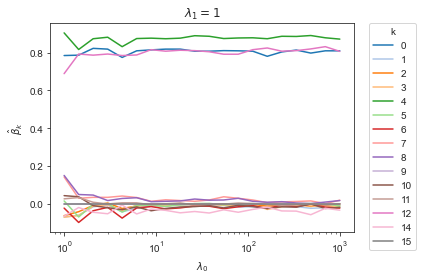

In [38]:
# Plot
g = sns.lineplot(
    data=all_effects[(np.abs(all_effects["lambda"]) >= 0.5)],
    x="lambda",
    y="Effect",
    hue="Node",
    palette="tab20"
)
g.set(xscale="log")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="k")
plt.title(r"$\lambda_1 = 1$")
plt.xlabel(r"$\lambda_0$")
plt.ylabel(r"$\hat{\beta}_k$")
plt.tight_layout()

# plt.savefig("traces_lambda_0.svg", format="svg", bbox_inches="tight")

plt.show()

## With lasso equivalent ($\lambda_0 = \lambda_1$, Figure S1D)

In [39]:
lambdas = np.round(np.logspace(start=-1, stop=3, num=20), 2)
print(lambdas)
results_lasso = {}

[1.0000e-01 1.6000e-01 2.6000e-01 4.3000e-01 7.0000e-01 1.1300e+00
 1.8300e+00 2.9800e+00 4.8300e+00 7.8500e+00 1.2740e+01 2.0690e+01
 3.3600e+01 5.4560e+01 8.8590e+01 1.4384e+02 2.3357e+02 3.7927e+02
 6.1585e+02 1.0000e+03]


In [ ]:
for l in lambdas:

    tree_mod = ana.CompositionalAnalysisTree(
    test_data,
    reference_cell_type="9",
    formula="x_0",
    reg="scaled",
    pen_args={"lambda_0": l, "phi":phi, "lambda_1": l},
    model="new"

    )
    tree_res = tree_mod.sample_hmc_da(num_results=20000, num_burnin=5000)
    results_lasso[l] = tree_res

In [41]:
thetas = pd.DataFrame({
    "l": lambdas,
    "theta": [np.mean(r.posterior["theta"].loc[{"x":0, "chain":0}]).item(0) for r in results_lasso.values()]
})
thetas.to_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/lasso_theta")
for k, res in results_lasso.items():
    res.node_df.to_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/lasso_{np.round(k, 2)}")

In [42]:
lasso_thetas = pd.read_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/lasso_theta", index_col=1)["theta"]
results_lasso = {}
for l in lambdas:
    results_lasso[l] = pd.read_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/lasso_{l}")


In [43]:
effects_lasso = []
for l, r in results_lasso.items():
    eff = pd.DataFrame({
        "Effect": r["Median"],
        "lambda": l,
        "theta": lasso_thetas[l],
        "Node": r["Node"]
    }).reset_index()

    effects_lasso.append(eff)

print(effects_lasso[-1])

all_effects_lasso = pd.concat(effects_lasso)

    index  Effect  lambda     theta  Node
0       0    -0.0  1000.0  0.067963     0
1       1    -0.0  1000.0  0.067963     1
2       2     0.0  1000.0  0.067963     2
3       3    -0.0  1000.0  0.067963     3
4       4    -0.0  1000.0  0.067963     4
5       5     0.0  1000.0  0.067963     5
6       6     0.0  1000.0  0.067963     6
7       7     0.0  1000.0  0.067963     9
8       8    -0.0  1000.0  0.067963     7
9       9    -0.0  1000.0  0.067963     8
10     10     0.0  1000.0  0.067963    10
11     11     0.0  1000.0  0.067963    11
12     12     0.0  1000.0  0.067963    12
13     13    -0.0  1000.0  0.067963    14
14     14     0.0  1000.0  0.067963    15


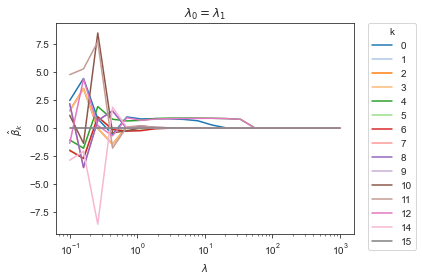

In [44]:
g = sns.lineplot(
    data=all_effects_lasso,
    x="lambda",
    y="Effect",
    hue="Node",
    palette="tab20"
)
g.set(xscale="log")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="k")
plt.title(r"$\lambda_0 = \lambda_1$")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\hat{\beta}_k$")
plt.tight_layout()

# plt.savefig("traces_lambda_lasso.svg", format="svg", bbox_inches="tight")

plt.show()

## Scaling $\lambda_1$ (Figure S1E)

[ 0.05  0.07  0.1   0.15  0.21  0.3   0.44  0.63  0.9   1.29  1.86  2.66
  3.82  5.48  7.87 11.29 16.2  23.24 33.35 47.86]


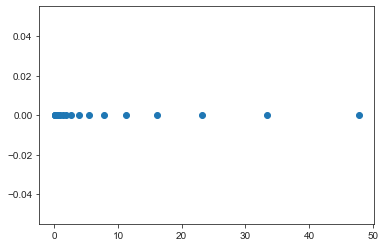

In [45]:
lambdas = np.round(np.logspace(start=-1.3, stop=1.68, num=20), 2)
print(lambdas)
plt.plot(lambdas, np.zeros(len(lambdas)), 'o')


In [7]:
results_l1 = {}
c=0
phi=0

for l in lambdas:
    c += 1
    print(f"{c}/{len(lambdas)}")

    tree_mod = ana.CompositionalAnalysisTree(
    test_data,
    reference_cell_type="9",
    formula="x_0",
    reg="scaled",
    pen_args={"lambda_0": 50, "phi":phi, "lambda_1": l},
    model="new"

    )
    tree_res = tree_mod.sample_hmc_da(num_results=20000, num_burnin=5000)
    results_l1[l] = tree_res

1/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


100%|██████████| 20000/20000 [02:09<00:00, 154.97it/s]


MCMC sampling finished. (168.380 sec)
Acceptance rate: 86.1%
2/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:16<00:00, 146.22it/s]


MCMC sampling finished. (171.918 sec)
Acceptance rate: 84.5%
3/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:57<00:00, 169.69it/s]


MCMC sampling finished. (148.440 sec)
Acceptance rate: 90.1%
4/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:51<00:00, 178.69it/s]


MCMC sampling finished. (142.000 sec)
Acceptance rate: 83.0%
5/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:53<00:00, 176.61it/s]


MCMC sampling finished. (142.934 sec)
Acceptance rate: 83.4%
6/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:55<00:00, 173.90it/s]


MCMC sampling finished. (144.946 sec)
Acceptance rate: 83.3%
7/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:51<00:00, 179.11it/s]


MCMC sampling finished. (142.106 sec)
Acceptance rate: 85.8%
8/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:52<00:00, 177.20it/s]


MCMC sampling finished. (142.741 sec)
Acceptance rate: 84.8%
9/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:57<00:00, 170.19it/s]


MCMC sampling finished. (148.025 sec)
Acceptance rate: 85.2%
10/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:00<00:00, 166.22it/s]


MCMC sampling finished. (150.761 sec)
Acceptance rate: 84.5%
11/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:00<00:00, 166.52it/s]


MCMC sampling finished. (151.686 sec)
Acceptance rate: 85.6%
12/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:11<00:00, 151.66it/s]


MCMC sampling finished. (165.071 sec)
Acceptance rate: 85.4%
13/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:00<00:00, 165.95it/s]


MCMC sampling finished. (152.037 sec)
Acceptance rate: 85.4%
14/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:01<00:00, 165.28it/s]


MCMC sampling finished. (152.296 sec)
Acceptance rate: 86.1%
15/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:57<00:00, 169.90it/s]


MCMC sampling finished. (148.490 sec)
Acceptance rate: 86.1%
16/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:57<00:00, 170.23it/s]


MCMC sampling finished. (149.173 sec)
Acceptance rate: 84.9%
17/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:01<00:00, 164.33it/s]


MCMC sampling finished. (153.265 sec)
Acceptance rate: 85.6%
18/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:59<00:00, 167.03it/s]


MCMC sampling finished. (150.406 sec)
Acceptance rate: 85.7%
19/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:04<00:00, 161.14it/s]


MCMC sampling finished. (156.753 sec)
Acceptance rate: 80.1%
20/20


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:447: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:03<00:00, 161.63it/s]


MCMC sampling finished. (156.208 sec)
Acceptance rate: 86.4%


In [47]:
thetas = pd.DataFrame({
    "l_1": lambdas,
    "theta": [np.mean(r.posterior["theta"].loc[{"x":0, "chain":0}]).item(0) for r in results_l1.values()]
})
thetas.to_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/l1_theta")
for k, res in results_l1.items():
    res.node_df.to_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/l1_{np.round(k, 2)}")

In [48]:
l1_thetas = pd.read_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/l1_theta", index_col=1)["theta"]
results = {}
for l in lambdas:
    results[l] = pd.read_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/l1_{l}")

In [49]:

effects_l1 = []
for l, r in results.items():
    eff = pd.DataFrame({
        "Effect": r["Median"],
        "lambda": l,
        "theta": l1_thetas[l],
        "Node": r["Node"]
    }).reset_index()

    effects_l1.append(eff)


print(effects_l1[-1])

all_effects_l1 = pd.concat(effects_l1)

    index  Effect  lambda     theta  Node
0       0    -0.0   47.86  0.066738     0
1       1    -0.0   47.86  0.066738     1
2       2    -0.0   47.86  0.066738     2
3       3    -0.0   47.86  0.066738     3
4       4     0.0   47.86  0.066738     4
5       5    -0.0   47.86  0.066738     5
6       6    -0.0   47.86  0.066738     6
7       7     0.0   47.86  0.066738     9
8       8     0.0   47.86  0.066738     7
9       9     0.0   47.86  0.066738     8
10     10    -0.0   47.86  0.066738    10
11     11     0.0   47.86  0.066738    11
12     12     0.0   47.86  0.066738    12
13     13    -0.0   47.86  0.066738    14
14     14     0.0   47.86  0.066738    15


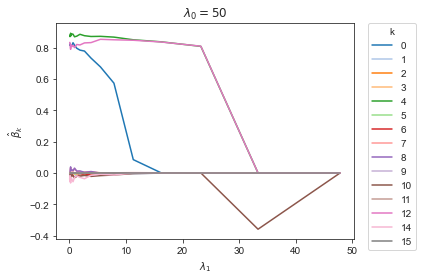

In [50]:
g = sns.lineplot(
    data=all_effects_l1,
    x="lambda",
    y="Effect",
    hue="Node",
    palette="tab20"
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="k")
plt.title(r"$\lambda_0 = 50$")
plt.xlabel(r"$\lambda_1$")
plt.ylabel(r"$\hat{\beta}_k$")
plt.tight_layout()

# plt.savefig("traces_lambda_1.svg", format="svg", bbox_inches="tight")
plt.show()

## Changing phi (Figure S1F)

In [51]:
phis = np.arange(-10, 10.1, 1)
print(phis)


[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


In [20]:
results_phi = {}
c=0
phi=0

for p in phis:
    c += 1
    print(f"{c}/{len(phis)}")

    tree_mod = ana.CompositionalAnalysisTree(
    test_data,
    reference_cell_type="9",
    formula="x_0",
    reg="scaled_3",
    pen_args={"lambda_0": 50, "phi":p, "lambda_1": 10},
    model="new"

    )
    tree_res = tree_mod.sample_hmc_da(num_results=20000, num_burnin=5000)
    results_phi[p] = tree_res

1/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:02<00:00, 109.88it/s]


MCMC sampling finished. (231.689 sec)
Acceptance rate: 84.7%
2/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:58<00:00, 111.76it/s]


MCMC sampling finished. (230.007 sec)
Acceptance rate: 84.5%
3/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:55<00:00, 114.28it/s]


MCMC sampling finished. (223.347 sec)
Acceptance rate: 85.6%
4/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:18<00:00, 100.57it/s]


MCMC sampling finished. (253.330 sec)
Acceptance rate: 85.5%
5/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:03<00:00, 108.79it/s]


MCMC sampling finished. (237.609 sec)
Acceptance rate: 85.3%
6/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:00<00:00, 110.55it/s]


MCMC sampling finished. (234.061 sec)
Acceptance rate: 85.2%
7/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:05<00:00, 108.01it/s]


MCMC sampling finished. (237.075 sec)
Acceptance rate: 86.5%
8/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:00<00:00, 111.01it/s]


MCMC sampling finished. (232.897 sec)
Acceptance rate: 85.7%
9/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:02<00:00, 109.51it/s]


MCMC sampling finished. (244.367 sec)
Acceptance rate: 85.4%
10/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:20<00:00, 99.55it/s] 


MCMC sampling finished. (262.708 sec)
Acceptance rate: 86.0%
11/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [03:09<00:00, 105.40it/s]


MCMC sampling finished. (232.919 sec)
Acceptance rate: 85.5%
12/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:05<00:00, 158.75it/s]


MCMC sampling finished. (165.133 sec)
Acceptance rate: 85.7%
13/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:01<00:00, 164.95it/s]


MCMC sampling finished. (169.458 sec)
Acceptance rate: 86.3%
14/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:02<00:00, 163.88it/s]


MCMC sampling finished. (153.692 sec)
Acceptance rate: 85.9%
15/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:01<00:00, 165.07it/s]


MCMC sampling finished. (152.971 sec)
Acceptance rate: 84.9%
16/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:00<00:00, 165.51it/s]


MCMC sampling finished. (152.107 sec)
Acceptance rate: 84.6%
17/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:06<00:00, 158.45it/s]


MCMC sampling finished. (168.108 sec)
Acceptance rate: 84.1%
18/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:09<00:00, 154.39it/s]


MCMC sampling finished. (167.209 sec)
Acceptance rate: 84.2%
19/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [02:07<00:00, 156.67it/s]


MCMC sampling finished. (165.002 sec)
Acceptance rate: 84.5%
20/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:56<00:00, 172.12it/s]


MCMC sampling finished. (149.686 sec)
Acceptance rate: 86.4%
21/21


/Users/johannes.ostner/Documents/PhD/tree_aggregation/tree_aggregation/tree_agg_model_sslasso.py:452: UserWarning: This feature is untested and might yield different results than expected. Please use sample_hmc().
  warnings.warn(
100%|██████████| 20000/20000 [01:59<00:00, 168.00it/s]


MCMC sampling finished. (158.880 sec)
Acceptance rate: 82.4%


In [56]:
thetas = pd.DataFrame({
    "phi": phis,
    "theta": [np.mean(r.posterior["theta"].loc[{"x":0, "chain":0}]).item(0) for r in results_phi.values()]
})
thetas.to_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/phi_theta")
for k, res in results_phi.items():
    res.node_df.to_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/phi_{np.round(k, 2)}")

In [57]:
phi_thetas = pd.read_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/phi_theta", index_col=1)["theta"]
results = {}
for p in phis:
    results[p] = pd.read_csv(f"../../../tascCODA_data/lambda_traces_supp_fig_1/phi_{p}")

In [58]:

effects_phi = []
for p, r in results.items():
    eff = pd.DataFrame({
        "Effect": r["Median"],
        "phi": p,
        "theta": phi_thetas[p],
        "Node": r["Node"]
    }).reset_index()

    effects_phi.append(eff)

print(effects_phi[-1])

all_effects_phi= pd.concat(effects_phi)

    index  Effect   phi     theta  Node
0       0   0.774  10.0  0.013169     0
1       1  -0.068  10.0  0.013169     1
2       2  -0.046  10.0  0.013169     2
3       3  -0.054  10.0  0.013169     3
4       4   0.853  10.0  0.013169     4
5       5  -0.015  10.0  0.013169     5
6       6  -0.052  10.0  0.013169     6
7       7   0.000  10.0  0.013169     9
8       8   0.838  10.0  0.013169     7
9       9   0.811  10.0  0.013169     8
10     10  -0.000  10.0  0.013169    10
11     11   0.001  10.0  0.013169    11
12     12   0.007  10.0  0.013169    12
13     13  -0.000  10.0  0.013169    14
14     14   0.000  10.0  0.013169    15


In [59]:
def delta(l_0, l_1, theta):
    p_t = (theta * l_1 / 2) / ((theta * l_1 / 2) + ((1 - theta) * l_0 / 2))
    return 1 / (l_0 - l_1) * np.log(1 / p_t - 1)

deltas = [delta(50, 1, phi_thetas[p]) for p in phis]
deltas_df = pd.DataFrame({
    "phi": phis,
    "delta": deltas,
    "delta_m": [-1*d for d in deltas],
})
deltas_df

,phi,delta,delta_m
0,-10.0,0.059845,-0.059845
1,-9.0,0.060043,-0.060043
2,-8.0,0.059770,-0.059770
3,-7.0,0.059667,-0.059667
4,-6.0,0.060238,-0.060238
5,-5.0,0.061550,-0.061550
6,-4.0,0.062301,-0.062301
7,-3.0,0.063987,-0.063987
8,-2.0,0.066165,-0.066165
9,-1.0,0.069005,-0.069005


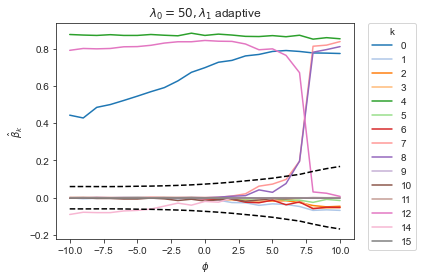

In [60]:
g = sns.lineplot(
    data=all_effects_phi,
    x="phi",
    y="Effect",
    hue="Node",
    palette="tab20"
)

sns.lineplot(data=deltas_df, x="phi", y="delta", color="black", linestyle="--")
sns.lineplot(data=deltas_df, x="phi", y="delta_m", color="black", linestyle="--")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="k")
plt.title(r"$\lambda_0 = 50, \lambda_1$ adaptive")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\hat{\beta}_k$")
plt.tight_layout()

# plt.savefig("traces_phi.svg", format="svg", bbox_inches="tight")
plt.show()